# Sampling Data -- A case study

In [251]:
# import matplotlib as mpl
%run prelude.py
XWL = np.genfromtxt("../datasets/WebLatency.csv", delimiter=",")[:,2] - 85

In [252]:
%matplotlib inline
mpl.rcParams['figure.figsize'] = (20,5)

10496


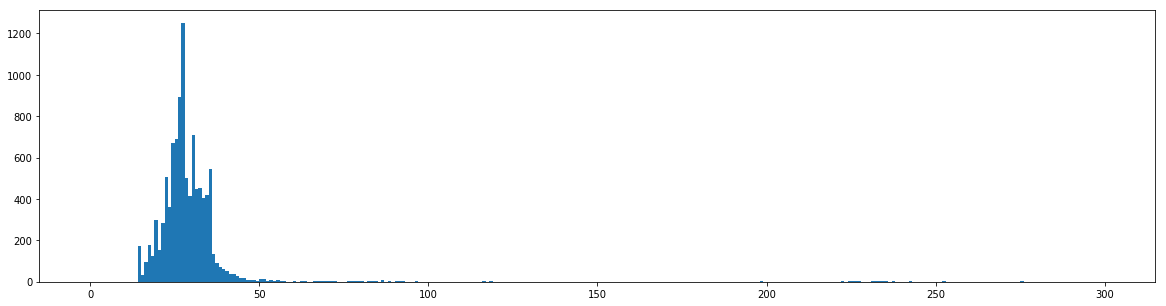

In [253]:
H("Dataset: Request Latencies")
Y = XWL
print(len(Y))
plt.hist(Y,range=(0,300),bins=300);
plt.show()
P(len(Y), "samples")

# Taking a Subsample

In [254]:
p = 0.05
def F(y): # filter function
    return np.random.random() < p

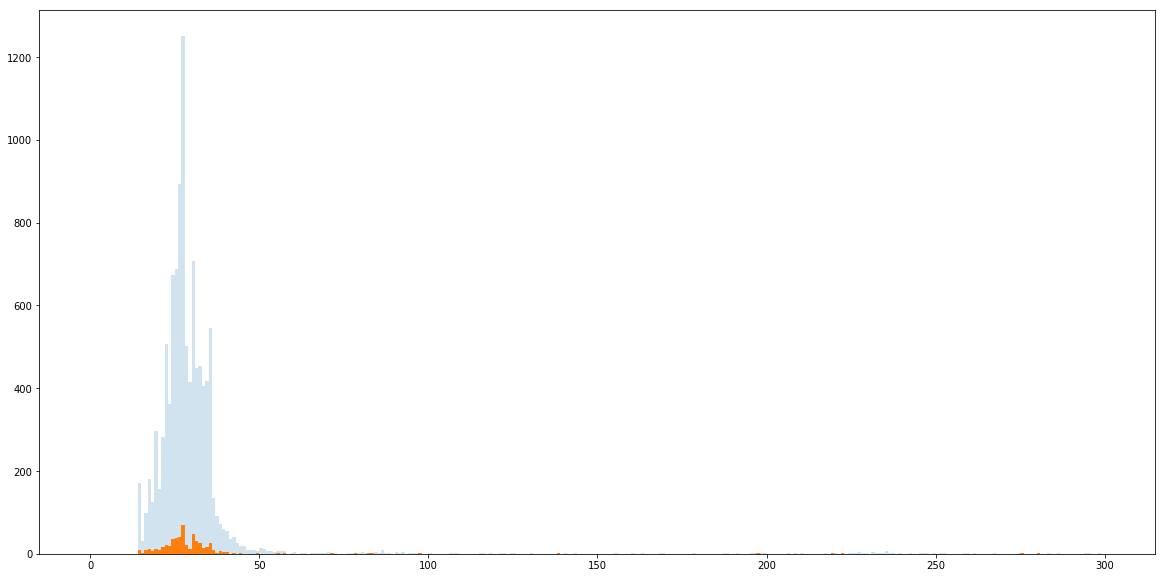

In [290]:
H("Subsample data")

SY = list(filter(F, Y))

plt.figure(figsize=(20,10))
plt.hist(Y, range=(0,300),bins=300, alpha=0.2)
plt.hist(SY,range=(0,300),bins=300)
plt.show()
P(len(SY),"samples")

In [295]:
# Statistics Calculated on SubSampled Data
def row(f):
    x = f(Y)
    y = f(SY)
    rerr = abs(x-y)/x*100
    return f(Y), f(SY), rerr

print(tabulate(
    [ 
        [ 'mean',   *row(lambda Y: np.mean(Y)) ],
        [ 'p50',    *row(lambda Y: np.percentile(Y, 50)) ],
        [ 'p90',    *row(lambda Y: np.percentile(Y, 90)) ],
        [ 'p99',    *row(lambda Y: np.percentile(Y, 99)) ],
        [ 'p99.9',  *row(lambda Y: np.percentile(Y, 99.9)) ],
        [ 'max',    *row(lambda Y: np.percentile(Y, 100)) ],
    ],
    headers = ",original data,sampled data,relative error %".split(","),
    floatfmt=".1f"
))

         original data    sampled data    relative error %
-----  ---------------  --------------  ------------------
mean              32.9            30.5                 7.4
p50               27.2            27.2                 0.0
p90               35.2            35.2                 0.0
p99              222.9           123.1                44.8
p99.9            834.1           277.6                66.7
max             1453.0           280.0                80.7


# Exterme percentiles highly depend on the choice of sample

  count     mean    spread    stddev      IQR
-------  -------  --------  --------  -------
     50  171.253    265.06   76.9525  142.956


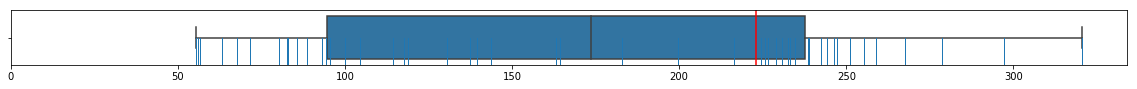

In [308]:
V = []
pct = 99
p=0.05
RUNS = 50

F = lambda x: np.random.random() < p
V = [ np.percentile(list(filter(F, Y)), pct) for _ in range(RUNS) ]

def summary(V):
    print(tabulate([[
        len(V), np.mean(V), np.max(V) - np.min(V), np.std(V), stats.iqr(V)
    ]], headers=["count", "mean", "spread", "stddev", "IQR"]))
    plt.figure(figsize=(20,1))
    sns.boxplot(V)
    sns.rugplot(V,height=.5)
    plt.xlim(0)

summary(V)
plt.axvline(np.percentile(Y, pct), color="red");

# Discussion
- Subsampling does capture typical values very well -> mean, p50 are usually pretty accuragte

- Extremal values are not captured well. E.g. max is systemtaically underestimated from a sample

- High percentiles (0.99,0.999) can have a very large relative error

# Statified Sampling

## Idea
- Use different probabilities for different ranges of the distribution
- Weight choosen samples by inverse probability to make-up for oversampling

In [318]:
# return weight along with sample
def wchoose(y, p):
    if np.random.uniform() < p: 
        return (y, 1/p)
    else:
        return (None, None)
    
def wsample(Y, F):
    SY = []
    for y in Y:
        y, w = F(y)
        if y:
            SY.append((y,w))
    return sorted(SY, key=lambda p : p[0])
        
# total weigth
def wtotal(SY): 
    W = 0
    for y,w in SY:
        W += w
    return W

# weighted percentile (approximation)
def wpercentile(SY, p):
    r = wtotal(SY) * p / 100.0
    W = 0
    for y, w in SY:
        W += w
        if W >= r:
            return y

  count     mean    spread    stddev    IQR
-------  -------  --------  --------  -----
     50  190.449     381.2    88.931  143.1


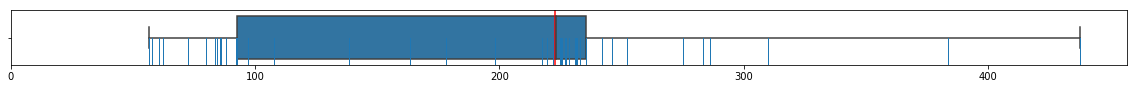

In [326]:
p = 0.05
pct = 99
RUNS = 50

def F(y): return wchoose(y, p)
summary([ wpercentile(wsample(Y, F), pct) for _ in range(RUNS) ])
plt.axvline(np.percentile(Y, pct), color="red")

Effective sampling rate: 5.040015243902439 


  count    mean    spread    stddev    IQR
-------  ------  --------  --------  -----
     50  212.03     109.9   24.3535  24.85

True percentile: 222.87 




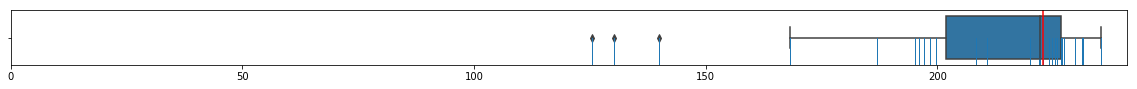

In [330]:
p = 0.05
pct = 99
RUNS = 50

# Stratified filter function
def F(y):
    if   y < 100:   return wchoose(y, 0.045)
    elif y < 500:   return wchoose(y, 0.50)
    else:           return wchoose(y, 1)

print("Effective sampling rate:", len(wsample(Y, F)) / len(Y) * 100, "\n\n")

summary([ wpercentile( wsample(Y, F), pct) for _ in range(RUNS) ])

print("\nTrue percentile:", np.percentile(Y, pct), "\n\n")
plt.axvline(np.percentile(Y, pct), color="red")

## Discussion

- Involves manual choices threshod choices

- Can be used to bring percentile errors into sensible bounds

- Need to control for effective sampling rate

# Related: The Bootstrap Method

Re-Sampling can be used to estimate errors for arbitrary statistics derived from a dataset.

Assume we have a dataset $X$ which is sampled from an unknown probability distribution P.
Now, we perform some arbitrary transformation $f$ on the data. We now want to know:

> How much does f(X) change, when X is replaced by another sample X' drawn from P?

A cheap, but workable, replacement for X' can be produced by simply resampling data from X itself.
We get a bootstrap replacement $B(X)$ from X by choosing $len(X)$ uniformly random elements from $X$.

- Bootstrap sample always has $\#X$ elements (no "subsampling")

- Repititions / omissions are allowed

In [277]:
def bootstrap(X):
    return np.random.choice(X, size=len(X), replace=True)

  count     mean    stddev       IQR
-------  -------  --------  --------
    100  32.9222  0.512929  0.663301


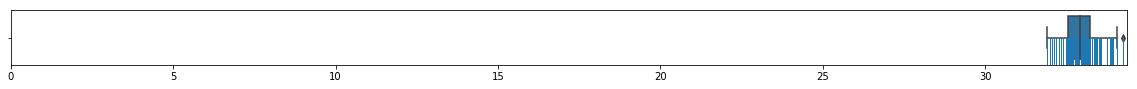

In [278]:
def f(X): return np.mean(X)

RUNS = 100
summary([ f(bootstrap(XWL)) for _ in range(RUNS) ])
plt.xlim(0);

  count    mean     stddev    IQR
-------  ------  ---------  -----
    100  27.242  0.0814616      0


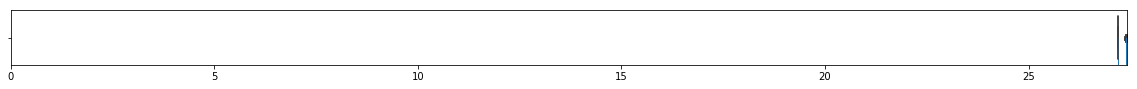

In [279]:
def f(X): return np.median(X)

RUNS = 100
summary([ f(bootstrap(XWL)) for _ in range(RUNS) ])
plt.xlim(0);

  count    mean     stddev    IQR
-------  ------  ---------  -----
    100  35.225  0.0653835      0


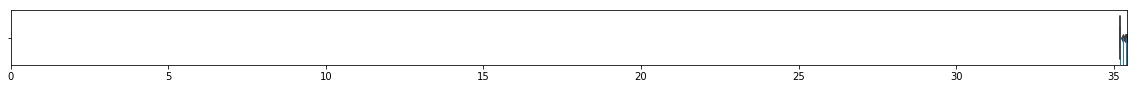

In [280]:
def f(X): return np.percentile(X, 90)

RUNS = 100
summary([ f(bootstrap(XWL)) for _ in range(RUNS) ])

  count     mean    stddev      IQR
-------  -------  --------  -------
    100  49.6912   4.10445  5.50248


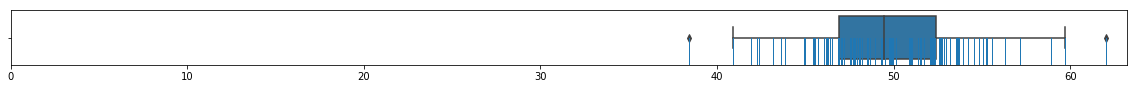

In [281]:
def f(X): return np.std(X)

RUNS = 100
summary([ f(bootstrap(XWL)) for _ in range(RUNS) ])
plt.xlim(0);

## Exercise: Regression Bootstrap

Use the bootstrap method to estimate the errors of a regression forecast as follows:

1. Import suitable dataset (TBD)
   The dataset will have two columns `[ (t, y), ... ]`
   
2. Adapt the bootstrap() function to work with pairs of data.

3. Calculate a regression on the imported dataset, and estimate the value 3days into the future.

4. Re-run the calculation with a bootstrap-replacement multiple times

5. Summarize the calculated bootstrap values with the provided `summary()` function